In [1]:
# Data Processing
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns   # plotting heatmap
import matplotlib.pyplot as plt
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from scipy.stats import randint
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [2]:
# Get data features and labels
# Split the data into features (X) and target (y)

sentiment_data = pd.read_csv(f'{os.getcwd()}/dataset/review_sentiment_labelled.csv')
X = sentiment_data["Sentence"]
y = sentiment_data['Score']
train_sentiment, test_sentiment, train_score, test_score = train_test_split(X, y, test_size=0.2)
print(sentiment_data.dtypes)
vectorizer = CountVectorizer()

vector_sentiment_train = vectorizer.fit_transform(train_sentiment)
vector_sentiment_test = vectorizer.transform(test_sentiment)


Sentence    object
Score        int64
dtype: object


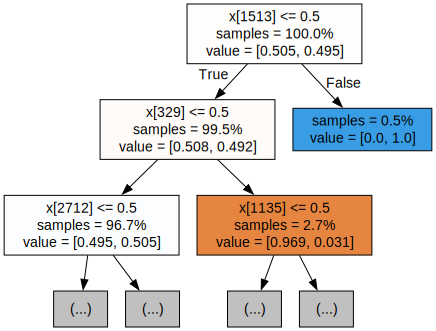

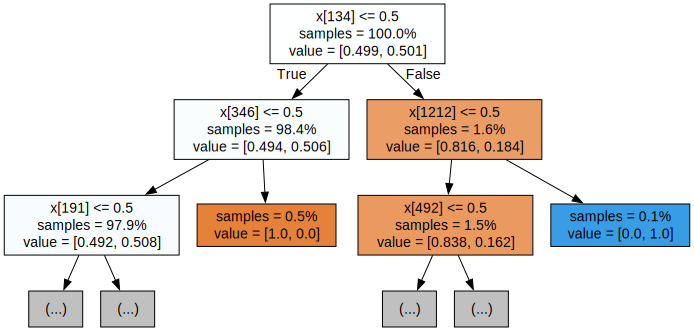

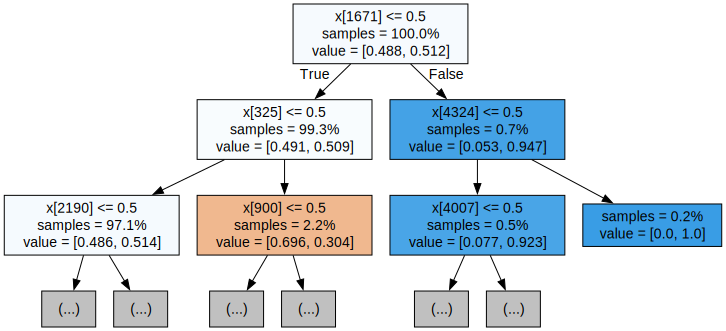

Best hyperparameters: {'max_depth': 14, 'n_estimators': 400}


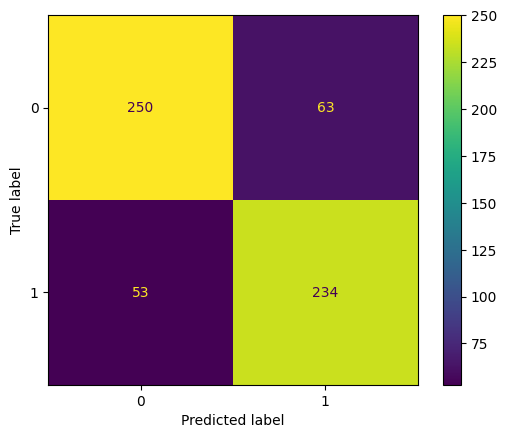

In [18]:
# Random Forrest Implementation
rf = RandomForestClassifier()
rf.fit(vector_sentiment_train, train_score)

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(vector_sentiment_train, train_score)
# # Create a variable for the best model
best_rf = rand_search.best_estimator_

# # Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

#Confusion Matrix setup, prediction with the best models
predicted_score_best = best_rf.predict(vector_sentiment_test)
cm = confusion_matrix(test_score, predicted_score_best)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();